In [8]:
##### This code is from Updated Testing Reddit - No Con- bias (Fictitious Play)-01092022
##### This code replace the big real datanetwork with small sythetic network 
import scipy
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations
import time
import random
from scipy.stats import beta
import pandas as pd
import copy
%matplotlib inline
%run pure_strategy_selection.ipynb  #include simple selection algorithm
import scipy.io
import collections
import sys
from itertools import count

## Mathmatic Functions

In [9]:
# centers the opinion vector around 0\n",
def mean_center(op, n):
    ones = np.ones((n, 1))
    x = op - (np.dot(np.transpose(op),ones)/n) * ones
    return x
    
# compute number of edges, m\n
def num_edges(L, n):
    m = 0
    for i in range(n):
        for j in range(n):
            if i > j and L[i,j] < 0:
                m += 1            
    return m

# maximizing polarization only: \\bar{z}^T \\bar{z}   
def obj_polarization(A, L, op, n):
    op_mean = mean_center(op, n)
    z_mean = np.dot(A, op_mean) 
    return np.dot(np.transpose(z_mean), z_mean)[0,0] 

def obj_polarization_1(A, L, op, n):
    z = np.dot(A, op) 
    z_mean = mean_center(z, n)
    return np.dot(np.transpose(z_mean), z_mean)[0,0] 

# Calculate innate polarization
def obj_innate_polarization(s, n):  
#     np.set_printoptions(precision=5)
    op_mean = mean_center(s, n)
    return np.dot(np.transpose(op_mean), op_mean)[0,0]

In [10]:
# Parameters for the network

np.set_printoptions(precision=3)

## Creating Network
### 1. Make Random Network

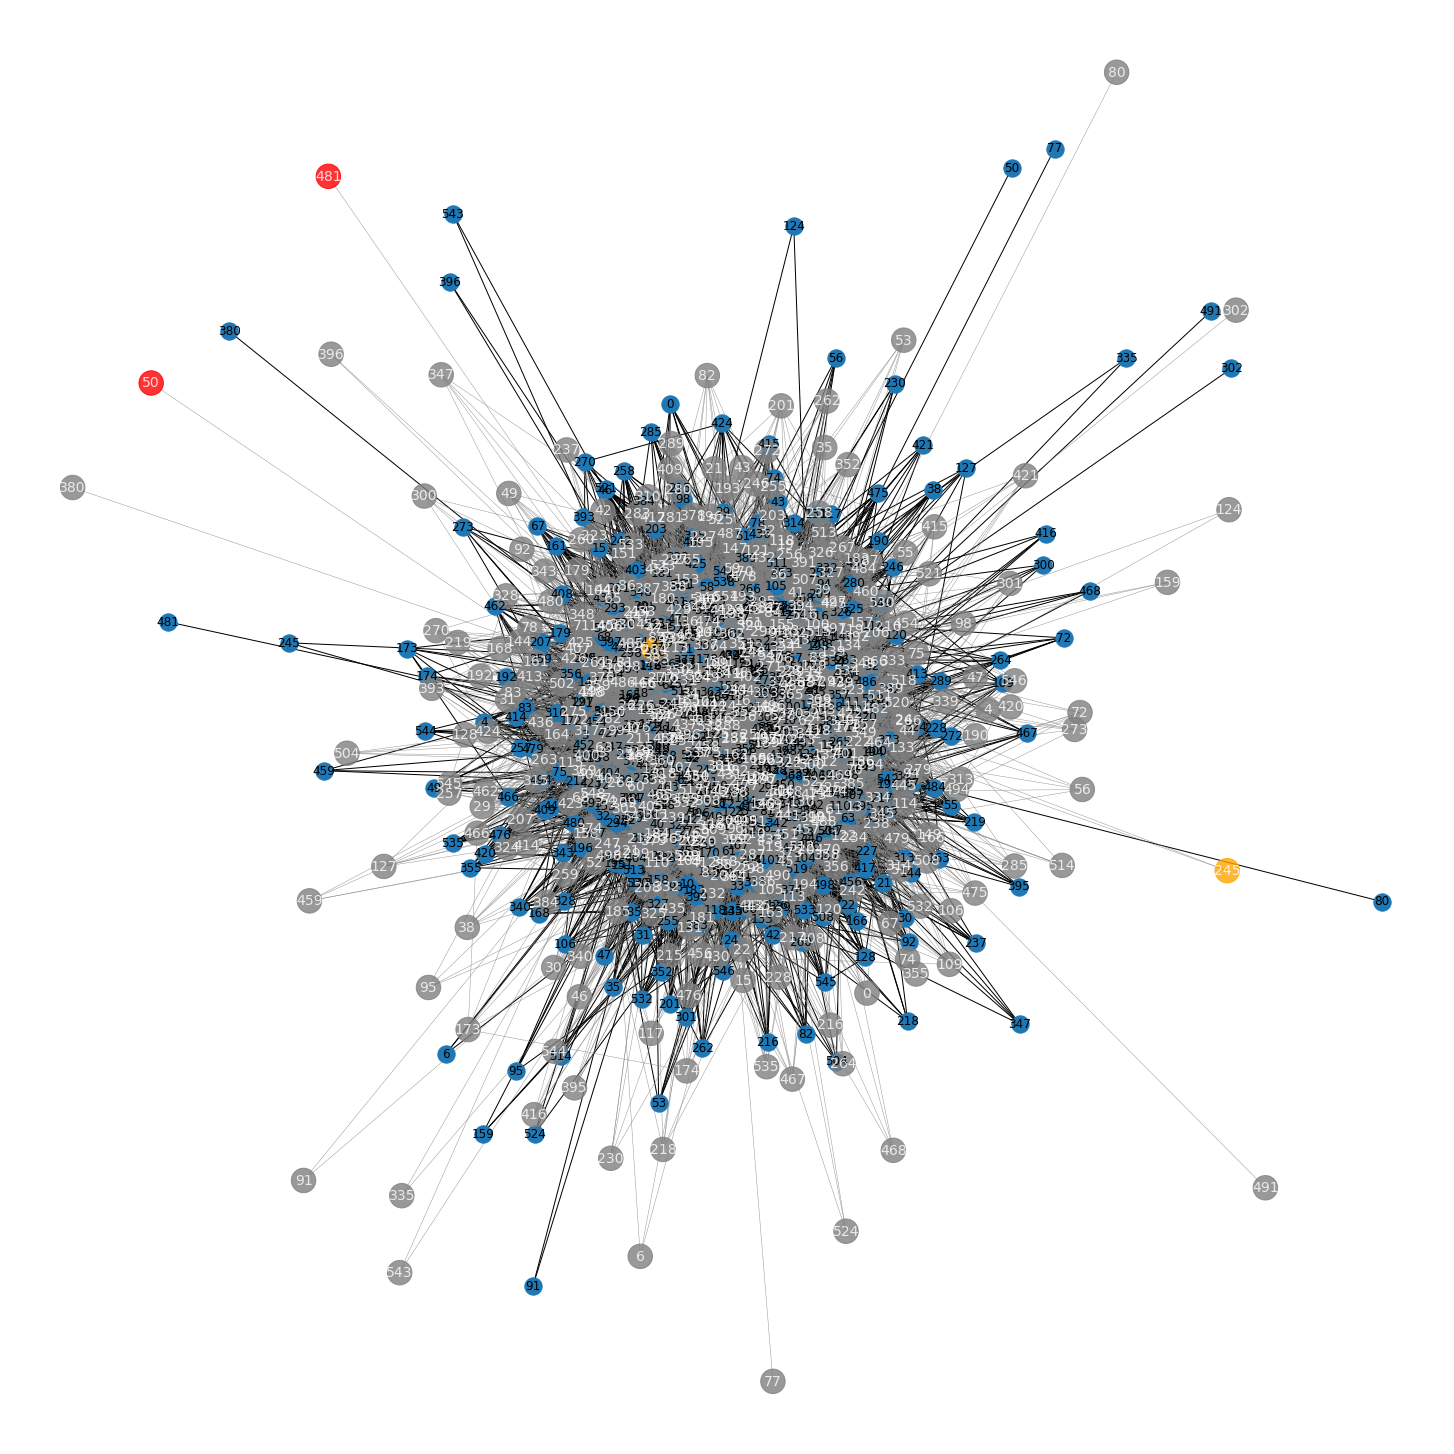

In [11]:
data = scipy.io.loadmat("Reddit.mat")
n = data['Reddit'][0,0][0].shape[0]     # number of vertices = 556
G = data['Reddit'][0,0][0].toarray()     # adjacency matrix in compressed sparse column format, convert to array
nodemap = data['Reddit'][0, 0][1]     # mapping from node ID to labels 1-556 (not important)
edges = data['Reddit'][0,0][2]     # list of edges (same as G, not used)
s = data['Reddit'][0,0][5]     # labeled "recent innate opinions"

# remove isolated vertices from the graph
s = np.delete(s, 551)
s = np.delete(s, 105)
s = np.delete(s, 52)
n -= 3
s = s.reshape((n , 1))
G = np.delete(G, 551, 1)
G = np.delete(G, 551, 0)
G = np.delete(G, 105, 1)
G = np.delete(G, 105, 0)
G = np.delete(G, 52, 1)
G = np.delete(G, 52, 0)

L = scipy.sparse.csgraph.laplacian(G, normed=False)  # Return the Laplacian matrix
A = np.linalg.inv(np.identity(n) + L)  # A = (I + L)^(-1)\n  Stanford paper theory
m = num_edges(L, n)                    # call the function to calculate the number of edges
columnsum_ij = np.sum(A, axis=0)
# print(columnsum_ij)
# what the twitter graph looks like 
s_use = s.flatten()
# round_s =[round(i,2) for i in s_use]
mapping ={index: value for index, value in enumerate(s_use)}
# print(mapping)
# sorted(nxG)
# print(nxG)

nxG = nx.from_numpy_matrix(G)   
# nxG = nx.relabel_nodes(nxG, mapping)
       
plt.figure(figsize=(20, 20))
nx.draw(nxG, with_labels=True)

# nx.draw(nxG, with_labels=True, node_color=color_map,  node_size = 600, edge_color='grey', width=0.5, font_color="white",font_size=14, alpha= 0.8)



### 4. Equilibrium & Polarization  - based on derivation
$$P(z) = z ^T * z $$


In [208]:

## s =  make_innat_opinions(n, c1)
# print('Innate Opinion')
# print(s)
# print('Equilibrium Opinion')
# print(np.dot(A, s))

op = s
y = mean_center(s,n)
# print(y)
innat_pol = np.dot(np.transpose(y), y)[0,0] 
print('Innate_polarization:')
print(innat_pol)

# Test equilibrium polarization
equ_pol = obj_polarization(A, L, s, n)
print('Equi_polarization:')
print(equ_pol)

di = equ_pol-innat_pol
print("Difference:")
print(di)

Innate_polarization:
0.9625703647920434
Equi_polarization:
0.005278437803904967
Difference:
-0.9572919269881384


### Testing players' behavior

In [209]:
def random_play(s,n):  # player randomly choose an agent and randomly change the agent
    
    op = copy.copy(s)
  
    v = random.randint(0,n-1)  # randomly select an agent index
#     print(v)
    new_op = random.randint(0, 1)  # randomly select an opininon between 0 and 1
#     print(new_op)
    
    # Store old opinion
    old_opinion = op[v,0]
    
    #update the opinion
    op[v,0] = new_op 
#     print('Only 1 opinion changed')
#     print(op)
    print("    "+"Agent" + str(v) +" 's opinion " + str(old_opinion) + " changed to "+ str(new_op))
    por = obj_polarization(A, L, op, n)
    
    #restore op op array to innate opinion
    op[v] = old_opinion
    print("Network reaches equilibrium Polarization: " + str(por))
#     print('Should be restored')
#     print(op)
    return (v, new_op, por)





In [210]:
def random_play1(s,n):  # player randomly choose an agent and randomly change the agent
    
    op = copy.copy(s)
#     max_opi_option = random.uniform(0, 1)   # options that maximizer have
    
    v = random.randint(0,n-1)  # randomly select an agent index
#     print(v)
#     v = 1
    new_op = random.uniform(0, 1)  # randomly select an opininon between 0 and 1
    #new_op = 0
#     print(new_op)
    
    # Store old opinion
    old_opinion = op[v,0]
    
    #update the opinion
    op[v,0] = new_op 
#     print('Only 1 opinion changed')
#     print(op)
    print("    "+"Agent" + str(v) +" 's opinion " + str(old_opinion) + " changed to "+ str(new_op))
    por = obj_polarization(A, L, op, n)
    
    #restore op op array to innate opinion
    op[v] = old_opinion
    print("Network reaches equilibrium Polarization: " + str(por))
#     print('Should be restored')
#     print(op)
    return (v, new_op, por)





In [211]:
## Testing to see if random_play works -- NO NEED TO RUN
# min_touched =[]
# (v1, maxmize_op, innat_equi_por, max_por) = choose_max_vertex(s, n, min_touched)
# print(v1, maxmize_op, innat_equi_por, max_por)

In [212]:
## Testing to see if random_play works -- NO NEED TO RUN
# (v1, max_opinion, max_pol) = random_play(s,n)
# (v2, min_opinion, min_pol) = random_play(s,n)

In [213]:
def maximizer_fir_play(s,n,min_touched):    # maxmizer first-time play, greedy algorithm
    op = copy.copy(s)

    print('Maximizer Play')

    max_champion = choose_max_vertex(op, n, min_touched) # The best choice among all opinions and vertexs, function is in "pure_strategy_selection.ipynb"
    (v1, max_opinion, innate_obj, max_pol) = max_champion # find agent v1, and max_opinion that can maxmize the equi_polarization(max_pol)

    if v1 == None:   # if maximizer cannot find one
        print('Maximizer fail')

    else:
        print("                                ")
        print("Maximizer finds its target agent:")
#         print('v1', 'changed_opinion', 'innate_obj', 'obj')
#         print(max_champion)

        #Store innate_op of the max_selected vertex
        old_opinion_max = op[v1, 0]
        ##### change the agent's opinion with best action(agent v1, max_op)
        op[v1,0] = max_opinion
        ## check if agent's opinionis is changed or not
        print("    "+"Agent" + str(v1) +" 's opinion " + str(old_opinion_max) + " changed to "+ str(max_opinion))
        print("Network reaches equilibrium Polarization: " + str(max_pol))


    return(v1, max_opinion, max_pol)

In [214]:
# max_touched = []
# min_touched = []
# (v1, max_opinion, max_pol) = maximizer_fir_play(s,n,min_touched)
# print(v1, max_opinion, max_pol)

In [215]:
##### minimizer first-time play, greedy algorithm
def minimizer_fir_play(s,n,max_touched): 
    
    op = copy.copy(s)
    print('_______________________')
    print('Minimizer Play')
#     print('Only 1 opinion changed')
#     print(op)
    
    min_champion = choose_min_vertex(op, n, max_touched)
    (v2, min_opinion, innat_equi_por, min_pol) = min_champion
    
   #Store innate_op of the min_selected vertex
    old_opinion_min = op[v2,0]
    
    if v2 == None:
        print('Minimizer fail')

    else:
        print("                                ")
        print("Minimizer finds its target agent:")

        ##### change the agent's opinion
        op[v2,0] = min_opinion   #-------------------------------------------------> store minimize strategy


        print("    "+"Agent" + str(v2) +" 's opinion " + str(old_opinion_min) + " changed to "+ str(min_opinion))

        print("Network reaches equilibrium Polarization: " + str(min_pol))
#         print('2 opinion changed')
#         print(op)

    return (v2,min_opinion, min_pol)

In [216]:
# max_touched = []
# min_touched = []
# (v2, min_opinion, min_pol) = minimizer_fir_play(s,n,max_touched)
# print(v2, min_opinion, min_pol)

In [217]:
## Testing above functions
# min_touched=[]
# max_touched=[]
# # Game start from maximizer random play
# print('Maximizer random selection')
# (v1, max_opinion, max_pol) = random_play(s,n)
# max_touched.append(v1)
# # print('v1, max_opinion, max_pol')
# # print(v1, max_opinion, max_pol)
# # store maximizer play history, using agent(row) and changed opinion(column) as indicator to locate history




# # Game start from minimizer random play 
# print('Minimizer random selection')
# (v2, min_opinion, min_pol) = minimizer_fir_play(s,n,max_touched)
# min_touched.append(v2)



In [218]:
# Row are Column are depended on min and max's choice: agent v and opinion 
def row_index(v2, min_opinion):
    row = 11*v2 + min_opinion*10 
    return int(row)
def column_index(v1,max_opinion):
    column = 2*v1 + max_opinion
    return int(column)  #the python dataframe index

### Mixed Strategy Payoff


In [219]:
def make_payoff_row(op1,v2):
    payoff_row = np.zeros(2*n)
    v1 = 0
#     print('one opinion changed -min')
#     print(op1)
    for column in range(2*n):
#         print(column)
        v1 = int(column/2)  #i.e., column 11 is agent 5, opinion 1
        max_opinion = column%2
#         print(v1, max_opinion)
        # update the maximizer's change to the opinion array that has changed by minimizer(op1)
        op2 = copy.copy(op1)
#         temp = op1[v1]
        op2[v1,0] = max_opinion
#         print('max_opinion')
#         print(v1, max_opinion)
#         print('two opinion changed -min +  max')
#         print(op2)
        # calculate the polarization with both max and min's action
        payoff_row[column] = obj_polarization(A, L, op2, n)
#         op1[v1,0] = temp # restore
#         print(op2,payoff_row[column])
    # when v1 == v2, the polarization should be negative for max, infinet for min. 
    # Replace the the column_index of agent v2 with 0 for max
    j_1 = 2*v2 + 0
    j_2 = 2*v2 + 1
    payoff_row[j_1] = -100
    payoff_row[j_2] = -100
    
    return payoff_row

In [222]:
# #(1,0) (2,0.3928571428571428)
# op1=copy.copy(s)
# print(op1)

op1 = copy.copy(s)
# print(op1)
op1[2,0] = 1  #op1 is the opinion array that updated by minimizer
# print(op1)
payoff_row_1 = make_payoff_row(op1,2)
print(payoff_row_1)


[0.009 0.008 0.005 ... 0.005 0.005 0.005]


### Minimizer Mixed Strategy

In [223]:
#NEEDDDDDDD UPDAE

# Calculate polarization of minimizer's Mixed Strategy
def mixed_min_polarization(s,v2,min_opinion,fla_max_fre):

    op1 =  copy.copy(s) # make a copy of the innate opinion array 
    op1[v2,0] = min_opinion # then only updated by minimizer's current change
#     print('update')
#     print(v2, min_opinion)
    # calculate the polarization with both min(did here) and max's action(in make_payoff_row)
    payoff_row = make_payoff_row(op1,v2)  # the vector list out 2*n payoffs after min's action combine with 2*n possible max's actions
    #print(payoff_row)

    # Replace the the column_index of agent v2 with 100 for min
    j_1 = 2*v2 + 0
    j_2 = 2*v2 + 1
    payoff_row[j_1] = 100
    payoff_row[j_2] = 100
    
#     print('Min Payoff Row')
#     print(payoff_row)
    #calculate fictitious payoff - equi_min  
    payoff_cal = payoff_row * fla_max_fre # fla_max_fre recorded the frequency of each maximizer's action, frequency sum = 1
                                             # payoff (2*n array) * maximizer_action_frequency (2*n array)

    mixed_pol = np.sum(payoff_cal) # add up all, calculate average/expected payoff


#     print('min_mixed_polarization')
#     print(mixed_pol)
        # Replace the the column_index of agent v2 with 100 for min

    payoff_row[j_1] = -100
    payoff_row[j_2] = -100

    return (mixed_pol,payoff_row)


In [224]:
# # op2=op
# # op2[0,0]=1
# # min_opinion1 = derivate_s(op2,n,1)
# # # print(min_opinion1)
# # min_opinion2 = derivate_s1(op2,n,1)
# # print(min_opinion2)
# v2 = 254
# min_opinion = 0
# (mixed_pol, payoff_row) = mixed_min_polarization(s,v2,min_opinion,fla_max_fre)
# print(np.nonzero(fla_max_fre))

In [225]:
def derivate_s(op,n,v2):
               #op - opinion array that updated by maximizer
    c = [1/n] * n
#     print(c)
    sum_term = 0
    j = 0

    sum_term = np.dot(np.dot((A-c),(A[v2]-c)),op)  # sum up all terms
    
    term_out = op[v2]*np.dot((A[v2]-c),(A[v2]-c)) # exclude the term that j = v2
    sum_s = sum_term - term_out    # numerator
    
    s_star = -sum_s/np.dot((A[v2]-c),(A[v2]-c))
    s_star = s_star[0] #take value out of array
    min_opinion =min(max(0,s_star),1)
            
    return min_opinion

# def derivate_s1(op,n,v2):
#                #op - opinion array that updated by maximizer
#     c = [1/n] * n
# #     print(c)
#     sum_term = 0
#     j = 0
#     for j in range(0,n):
#         term = op[j]*np.dot(np.transpose(A[j]-c),(A[v2]-c))
# #             print(A[j])
# #             print(A[v])
#         sum_term = sum_term + term  # sum up all terms
    
#     term_out = op[v2]*np.dot(np.transpose(A[v2]-c),(A[v2]-c)) # exclude the term that j = v2
#     sum_s = sum_term - term_out    # numerator
    
#     s_star = -sum_s/np.dot(np.transpose(A[v2]-c),(A[v2]-c))
#     s_star = s_star[0] #take value out of array
#     min_opinion =min(max(0,s_star),1)
            
#     return min_opinion



## Print out weighted opinion proved that we need to do this step insetead of min_mixed_opinion - we are weighting
# different min_opinion here
def min_mixed_opinion_1(s, n, v2, fla_max_fre):
    
    weight_op = 0
    
    # loop for each max_action(in total 2*n) 
    for column in range(2*n):

        if fla_max_fre[column] !=0:
            v1 = int(column/2)  #i.e., column 11 is agent 5, opinion 1
            max_opinion = column%2
            op = copy.copy(s)
            op[v1] = max_opinion
#             print(op)

#             print('Weight')
#             print(fla_max_fre[column])
            min_opinion = derivate_s(op, n, v2)# find min_s_star for each max_action


            
            op1 = copy.copy(op)
            op1[v2] = min_opinion   #after max action, update min action on opinion array
#             print(min_opinion)
            min_por = obj_polarization(A, L, op1, n)
            t = 0  
            weight_op = weight_op + fla_max_fre[column]*min_opinion # sum up p_i*s_i

#     print('Weighted opinion')
#     print(weight_op)
    
  
    (mixed_por, payoff_row) = mixed_min_polarization(s, v2, weight_op,fla_max_fre)

    return(weight_op,payoff_row,mixed_por)  

In [226]:
# print(v2,fla_max_fre)
# (weight_op_1,payoff_row,min_por) = min_mixed_opinion_1(s, n, v2, fla_max_fre)
# print(weight_op_1)

In [227]:
# a = obj_polarization(A, L, s, n) #min_por- set a standard to compare with pol after min's action
# # maxup_por = min_por # store innate max updated polarization
# print(a)
# print(s[253])
# op = copy.copy(s)
# op[253] = 0
# b = obj_polarization(A, L, op, n)
# print(b)


In [228]:
# Minimizer search: Go through each agent 

def mixed_choose_min_vertex(s, n, v1, max_opinion, max_touched, fla_max_fre):
    # current polarization that changed by maximizer, "innate" objective that min start with
    op = copy.copy(s)
    op[v1,0] = max_opinion
#     print('Check if op has been updated by Maximizer')
#     print(op)
    min_por = obj_polarization(A, L, op, n) #min_por- set a standard to compare with pol after min's action
    maxup_por = min_por # store innate max updated polarization
#     print('check maxup por')
#     print(maxup_por)
#     payoffs = []    # create an empty list to store all polarizations   
    champion = (None, None, 0, None)  # assume the best action is champion

    all = list(range(n))    # for all agent 
    C1 = [x for x in all if x not in max_touched]  # for the vertice that Maximizer has not touched
    
    for v2 in C1:   
#         print('Min start with agent '+ str(v2) )
        (changed_opinion, payoff_row, por) = min_mixed_opinion(op, n, v2, fla_max_fre)   # find the best new_op option           
#         print('changed opinion, por, Maxup_por')
#         print(changed_opinion, por, maxup_por)

        if por < min_por:  # if the recent polarization is smaller than the minimum polarization in the history
            min_por = por
                                 # update the recent option as champion
            champion = (v2, changed_opinion, payoff_row, min_por)  
#         else:
#             print('Innate polarization is smaller than Min action')

    return (champion)  # find the best minimizer's action after going through every new_op option of every agent


In [187]:
# print('v1,max_opinion')
# print(v1,max_opinion)
# champion = mixed_choose_min_vertex(s, n, v1, max_opinion, max_touched, fla_max_fre)
# print(champion)

v1,max_opinion
253 0


In [190]:
####Op has been updated by maximizer, fla_max_fre includes max's hisotry, so minimizer react to the innate op after that
def mixed_min_play(s,v1,max_opinion,n, max_touched,fla_max_fre): 

    print('_______________________')
    print('Minimizer Play')
#     print('Only 1 opinion changed')
#     print(op)
    
    min_champion = mixed_choose_min_vertex(s, n, v1, max_opinion, max_touched, fla_max_fre)
    (v2, min_opinion, payoff_row, min_pol) = min_champion
    
    if v2 == None:    # if minimizer cannot find a action to minimize polarization after maximizer's action
        print('Minimizer fail')

    else:
        print("                                ")
        print("Minimizer finds its target agent:")
#         print('v2', 'changed_opinion', 'innate_obj', 'obj')
#         print(v2, min_opinion, innat_equi_por, min_pol)

        # Store innate_op of the min_selected vertex
        old_opinion_min = op[v2,0]

        print("    "+"Agent" + str(v2) +" 's opinion " + str(old_opinion_min) + " changed to "+ str(min_opinion))
#         print("Payoff row")
#         print(payoff_row)
#         print("Network reaches equilibrium Polarization: " + str(min_pol))
#         print('2 opinion changed')
    return (v2, payoff_row, min_opinion, min_pol)                 

In [1]:
# print(max_touched)
# (v2, payoff_row, min_opinion, polarization) = mixed_min_play(s,v1,max_opinion,n, max_touched,fla_max_fre)
# # print('v2, payoff_row, min_opinion, polarization')
# # print(v2, payoff_row, min_opinion, polarization)

### Maximizer Mixed Strategy

In [193]:
####Op has been updated by minimizer, fla_min_fre includes min's hisotry, so maxmizer react to the innate op after that
def mixed_max_polarization(payoff_matrix,v1,max_opinion,fla_min_fre):

    # create payoff matrix for maxmizer
    column = int(column_index(v1,max_opinion))
#     print(payoff_matrix)
#     print("column"+str(column))
    payoff_vector = payoff_matrix[:,column]
    
#     print('payoff vector')
#     print(payoff_vector)

    #calculate fictitious payoff - equi_max   
    payoff_cal = payoff_vector * fla_min_fre #payoff * frequency
    
#     print('max_payoff_calculation')
#     print(payoff_cal)
    mixed_pol = np.sum(payoff_cal) # add up
#     print("Max_mixed_polarization")
#     print(mixed_pol)

    return mixed_pol


In [194]:
# mixed_pol = mixed_max_polarization(payoff_matrix,v1,max_opinion, fla_min_fre)

In [195]:
# determines if value of opinion at v should be set to 0 or 1 to maximize equilibrium polarization 
def max_mixed_opinion(payoff_matrix, n, v1, fla_min_fre):
    
    por_arr = np.zeros(2)  # create a two_element array to store polarization value of each option


    max_opi_option = [0, 1.0]   # Maximizer has two options to change agent v1's opinion
    
    # objective if set opinion to 0, 1.0
    j = 0
    for new_op in max_opi_option:
#         print('change op to '+ str(i/10))
        max_opinion = new_op

        por_arr[j] = mixed_max_polarization(payoff_matrix,v1,max_opinion, fla_min_fre)
    
        j = j + 1   # index increase 1, put the polarization in array

#     print('Polarization Options')
#     print(por_arr)
    
    maxmize_op = np.argmax(por_arr)  # the index of maximum polarization = max_opinion --[0,1]
    max_por = np.max(por_arr)        # find the maximum polarization in the record
 
#     print('new_op', 'innat_equi_por', 'max_por')
#     print(maxmize_op, innat_equi_por, max_por)

    return (maxmize_op, max_por)

In [196]:
# fla_min_fre = [0, 0, 0, 0, 0.65, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.35, 0, 0, 0]
# v1 = 2
# champion = max_mixed_opinion(payoff_matrix, n, v1, v2, fla_min_fre)
# print(champion)

In [197]:
# determine which agent maximizer should select to maximizer the equilibrium polarization
def mixed_choose_max_vertex(payoff_matrix,op, n, min_touched, fla_min_fre):
#     print('Check if op has been updated by minimizer')
#     print(op)
    max_por = obj_polarization(A, L, op, n)  # use "innate"(after min action) polarization as a comparable standard to find max_por
    minup_por = max_por # store innate min_update polarization
#     print('check minup por')
#     print(minup_por)
    champion = (None, None, max_por)  # assume champion is the best action

    all = list(range(n))    # for all agent 
    C1 = [x for x in all if x not in min_touched]  # for the vertice that Minimizer has not touched
    for v1 in C1:  
#             print('Maximizer start from agent'+str(v1))
            (changed_opinion, por) = max_mixed_opinion(payoff_matrix, n, v1, fla_min_fre)
#             print('changed_opinion, por, minup_por')
#             print(changed_opinion, por,minup_por)
            
            if por > max_por: # if the polarization of most recent action > maximum polarization of previous actions
                max_por = por
                champion = (v1, changed_opinion,max_por)   # save the this action as champion    
#             else:
#                 print('Innate polarization is bigger than max action')
 
    return (champion)


In [198]:
# print(payoff_matrix)
# champion = mixed_choose_max_vertex(payoff_matrix,op, n, min_touched, fla_min_fre)

[[0.156 0.169 0.18  ... 0.006 0.035 0.   ]]


In [199]:
# # min_touched = []
# # payoff_matrix = np.empty((0, 2*n), float)
# # fla_min_fre = np.empty((0,n))
# # champion = mixed_choose_max_vertex(payoff_matrix,op, n, min_touched, fla_min_fre)
# # print(champion)
# print(c1)
# vertices = np.where(c1)
# print(vertices)
# por=0
# for i in c1:
#     print(i)
#     max_por = 0.75
#     if por > max_por:
#         max_por = por
#         print('yes')
#     else:
#         print('por<max')

In [200]:
def mixed_max_play(payoff_matrix,s,v2,min_opinion,n,min_touched,fla_min_fre): 
    op = copy.copy(s)   # op is a copy of innate opinion
    
    #update innat opinion 
    op[v2,0] = min_opinion  # Op has been updated by minimizer, so maximizer react to the innate op after that
    

    max_champion = mixed_choose_max_vertex(payoff_matrix,op, n, min_touched, fla_min_fre) # The best choice among all opinions and vertexs
    (v1, max_opinion, max_pol) = max_champion

    if v1 == None:
        print('Maximizer fail')

    else:
        print("                                ")
        print("Maximizer finds its target agent:")
        #Store innate_op of the max_selected vertex
        old_opinion_max = op[v1, 0]
        
        ## check if agent's opinionis is changed or not
        print("    "+"Agent" + str(v1) +" 's opinion " + str(old_opinion_max) + " changed to "+ str(max_opinion))
#         print("Network reaches equilibrium Polarization: " + str(max_pol))
#         print('2 opinion changed')
#         print(op)

    return(v1, max_opinion, max_pol)

In [201]:
# # # Testing function -- NO NEED TO RUN
# min_touched = []
# v2 = 0
# min_opinion = 0
# b = mixed_max_play(payoff_matrix,s,v2,min_opinion,n,min_touched,fla_min_fre)
# print('v1,max_opinion,max_pol')
# print(b)

### Testing Player's Behavior

# 5. Innate Op and Game

# Fictitious Play Start !


In [ ]:
op = s
y = mean_center(s,n)
# print(y)
innat_pol = np.dot(np.transpose(y), y)[0,0] 
print('Innate_polarization:')
print(innat_pol)

# Test equilibrium polarization
equ_pol = obj_polarization(A, L, op, n)
print('Equi_polarization:')
print(equ_pol)

di = equ_pol-innat_pol
print("Difference:")
print(di)



In [203]:
Network = 'Reddit'
memory = 50


# with open('Network_'+str(Network)+'.txt', "a") as fi:
#     print('Innate Opinion', file=fi)
#     print(s, file=fi)
#     print('Adjacency Matrix', file=fi)
#     print(G,file=fi)

# Game Preparation
def push(obj, element):
    if len(obj) >= memory:
        obj.pop(0)
        print('pop')
    obj.append(element)
    return obj


In [229]:
# Game Parameters
Game_rounds =801 # Rounds + 1- use for printing data

def all_fre_limited_touch(s, n):
    # Preparation for the game
    op = copy.copy(s)
    payoff_matrix = np.empty((0, 2*n), float)
    max_history = np.zeros([n, 2])  # n*2 matrix, agent i & opinion options
    min_history = []  # append a list of (agent i, min_opinion), min_opinion can be any value
#     print(type(min_history))

    max_history_last_100 = np.zeros([n, 2]) 
    min_history_last_100= []

    max_touched = []
    min_touched = []
    min_touched_all = []
    min_touched_last_100 =[]
    print('min_touched')
    print(min_touched)
    
    
    # Game start from maximizer random play
    print('Maximizer first selection')
    (v1, max_opinion, max_pol) = random_play(op,n)   # Maximizer does random action 
    #(v1, max_opinion, max_pol) = maximizer_fir_play(s,n,min_touched)
    #(v1, max_opinion, max_pol) = (2, 1, 0.14833274000237331)
    First_max = (v1, max_opinion, max_pol) 


#     (v1, max_opinion, max_pol) = maximizer_fir_play(s,n,max_touched)

    # Maximizer start with greedy play
    # (v1, max_opinion, max_pol) = maximizer_fir_play(s,n,min_touched)   # Maximizer choose action greedily
    max_touched.append(v1)    # save Maximizer's action history

    # store maximizer play history, using agent(row) and changed opinion(column) as indicator to locate history
    max_history[v1,int(max_opinion)] = max_history[v1,int(max_opinion)] +1
    # print('max_history')
    # print(max_history)
    print('history at spot')
    print(max_history[v1,int(max_opinion)])

    max_frequency = max_history/1  # its frequency, only played  1 time so far, divided by 1 
    # print('fre_max at spot')
    # print(max_frequency[v1,int(max_opinion)])

    fla_max_fre = max_frequency.flatten()   # flatten the n*2 matrix to a 2n*1 matrix
                                            # so we can multiply the freuency (2n*1)with payoff array (1*2n) 
                                            # to get average payoff of fictitious play
    print('fre_max at spot')
    print(fla_max_fre)

    column = int(column_index(v1,max_opinion))    # the frequency of maximizer's most recent action (v1,max_opinion)

    print(fla_max_fre[column])

    # print(np.shape(fla_max_fre.shape))


    # if game start from minimizer random play - make sure two random play are not same agent!!!
    print('Minimizer first selection')
    (v2, min_opinion, min_pol) = random_play(op,n) 
    #(v2, min_opinion, min_pol) = minimizer_fir_play(s,n,min_touched)
    
    #(v2, min_opinion, min_pol) = (1, 0, 0.5933309600094931)
    First_min = (v2, min_opinion, min_pol)

    if v1==v2:   # if Max and Min randomly selected the same agent, then we need to restart - cannot choose same agent
        sys.exit()

    # Minimizer start with greedy play
    # (v2, min_opinion, min_pol) = minimizer_fir_play(s,n,max_touched)

    min_touched.append(v2)
   

    # store minimizer play history
    min_history.append((v2,min_opinion))
    print('min_history')
    print(min_history)


    counter=collections.Counter(min_history)  #return a dictionary include {'min_option': count of this choice}
    print(counter)
    fla_min_fre = np.array(list(counter.values()))/1 #return only frequency of all min options in order
#     print('fla_min_fre')
#     print(fla_min_fre)


    (a,payoff_row) = mixed_min_polarization(s,v2,min_opinion,fla_max_fre)
    payoff_matrix = np.vstack([payoff_matrix, payoff_row])
#     print('Payoff Matrix')
#     print(payoff_matrix)
    print('fla_min_fre at the spot')
    min_counter = dict(counter)
    print(min_counter) 
    print(min_counter[(v2,min_opinion)]) 
#     print(min_counter[(v2,min_opinion)]/(i+1)) #get the value from dictionary by using key (v2,opinion)


    equi_min = min_pol
    equi_max = max_pol
    # print(equi_min)
    # print(equi_max)



    Flag = 0

    i = 0
    while Flag == 0: 
        i = i + 1
        print("Game " + str(i))
        print("_____________________")

    #     if max_pol == min_pol:
        if i == Game_rounds:            # i == # of iterations you want to run + 2
                                # because Game 101 is skipped for collecting data, to get 200 game result, we need to run 201 iteration
            print('min_recent_'+str(memory)+'_touched')# then stop at Game 202
            print(min_touched)
            print('max_recent_'+str(memory)+'_touched')
            print(max_touched)
            print('Min last 100 action')
            print(min_touched_last_100)

            break

        elif equi_min == equi_max:
            print("Reached Nash Equilibrium at game"+ str(i) + "and Equi_Por = " + str(equi_min))
            print('max_distribution')
            print(max_frequency)
            print('min_distribution')
            print(fla_min_fre)
            Flag = 1
            break
        ############################## maximizer play  
        else:
            if i == Game_rounds-100:    #if Game_round = 200, after 100 iteration, Game 101 print previous historical result
    #             max_touched_100 = max_touched 
    #             min_touched_100 = min_touched
    #             max_fre_100 = max_frequency  # store the max_frequency of first 100 iterataions
    #             print('max_history')
    #             print(max_history)
    #             min_fre_100 = fla_min_fre  # max_frequency of first 100 iterations
    #             print('min_history')
    #             print(min_history)
    # Remove max frequncy less than 0.1--
                max_history_last_100 = np.zeros([n, 2]) 
                min_history_last_100 = [] 
                min_touched_last_100 =[]

            (v1, max_opinion, equi_max) = mixed_max_play(payoff_matrix,s,v2,min_opinion,n,min_touched,fla_min_fre)
            max_touched = push(max_touched, v1)
    #         print('min_touched')
    #         print(min_touched)
    #         print('max_touched')
    #         print(max_touched)
    #             print('equi_max')
    #             print(equi_max)
    #         print(v1, max_opinion, max_pol)
            # cumulate strategy 
            max_history[v1,int(max_opinion)] = max_history[v1,int(max_opinion)] +1

            max_history_last_100[v1,int(max_opinion)] = max_history_last_100[v1,int(max_opinion)] +1
    #         print('max_history')
    #         print(max_history)
    #________________________________________________________________
            max_frequency = max_history/(i+1)  # its frequency 
    #         print('max_distribution')
    #         print(max_frequency)
        #     print(i+1) 
            fla_max_fre = max_frequency.flatten() #flaten max_frequency to calculate average payoff
#             print('fla_max_fre')
#             print(fla_max_fre)
            print('fre_max at spot')
            print(fla_max_fre[column])
            # create payoff matrix for maxmizer
            row = int(row_index(v2, min_opinion))
            column = int(column_index(v1,max_opinion))

    # _________________________________________________________________
    #         ######################Visualize Maximizer's selection
    #         La = scipy.sparse.csgraph.laplacian(G, normed=False)

    #         nxG = nx.from_numpy_matrix(G)

    #         color_map = []
    #         for node in nxG:
    #             if node == v1:
    #                 color_map.append('Red')
    #             else: 
    #                 color_map.append('Grey')  

    #         #nxG1 = nx.DiGraph(G)
    #         nx.draw(nxG, node_color=color_map, with_labels=True,node_size = 50)
    #         plt.figure(figsize=(200, 200))
    #         plt.show()



    ############################### minimizer play
            (v2, payoff_row, min_opinion, equi_min) = mixed_min_play(s,v1,max_opinion,n, max_touched,fla_max_fre)
            min_touched = push(min_touched, v2)
            min_touched_all.append(v2) 
            min_touched_last_100.append(v2)
    #         print('min_touched')
    #         print(min_touched)
    #         print('equi_min')
    #         print(equi_min)
    #         print('max_touched')
    #         print(max_touched)
            #         print(v2, min_opinion, min_pol)
            if (v2,min_opinion) in counter.keys():
                payoff_matrix = payoff_matrix # if this min_option is in min_history, no need to update paryoff matrix, only update frequency
                print("Same history")
                print((str(v2),str(min_opinion)))
            else:
                payoff_matrix = np.vstack([payoff_matrix, payoff_row]) # if this is a new option, append to previous matrix
    #                 print('payoff_row')
    #                 print(payoff_row)
            min_history.append((v2,min_opinion))
            min_history_last_100.append((v2,min_opinion))
            #         print('min_history')
            #         print(min_history)
            counter=collections.Counter(min_history)  #return a dictionary include {'min_option': count of this choice}
            #print(counter)
    #         print('counter.keys')
    #         print(counter.keys())
            fla_min_fre = np.array(list(counter.values()))/(i+1) #return only frequency of all min options in order
    #         print('fla_min_fre')
    #         print(fla_min_fre)

    #         print('fla_min_fre at the spot')
    #         min_counter = dict(counter)
    #         print(min_counter[(v2,min_opinion)]/(i+1)) #get the value from dictionary by using key (v2,opinion)

            # create payoff matrix for minimizer
            row = row_index(v2, min_opinion)
            column = column_index(v1,max_opinion)
            #     print('row, column')
            #     print(row, column)

            print("Not Reached Nash Equilibrium at Equi_Min = " + str(equi_min) + " and Equi_Max = "+ str(equi_max)) 
    #         print('min_distribution')
    #         print(fla_min_fre)

            ######################Visualize Minimizer selection
    #         La = scipy.sparse.csgraph.laplacian(G1, normed=False)

    #         nxG = nx.from_numpy_matrix(G1)

    #         color_map = []
    #         for node in nxG:
    #             if node == v2:
    #                 color_map.append('Blue')
    #             else: 
    #                 color_map.append('Grey')  

    #         #nxG1 = nx.DiGraph(G)
    #         nx.draw(nxG, node_color=color_map, with_labels=True)
    #         plt.figure(figsize=(25, 25))
    #         plt.show()
    return (First_max, First_min, max_touched, min_touched, payoff_matrix, min_history, fla_min_fre, min_history_last_100, min_touched_last_100, min_touched_all, max_history, max_history_last_100)



In [205]:
Experiment = 1

Experiment_note = str('Note: This experiement has initial condition. Game round:'+str(Game_rounds)+'.')
(First_max, First_min, max_touched, min_touched, payoff_matrix, min_history, fla_min_fre, min_history_last_100, min_touched_last_100, min_touched_all, max_history, max_history_last_100) = all_fre_limited_touch(s, n)


min_touched
[]
Maximizer first selection
    Agent323 's opinion 0.61157 changed to 1
Network reaches equilibrium Polarization: 0.16535083293393488
history at spot
1.0
fre_max at spot
[0. 0. 0. ... 0. 0. 0.]
1.0
Minimizer first selection
    Agent451 's opinion 0.659389 changed to 0
Network reaches equilibrium Polarization: 0.17716456251354767
min_history
[(451, 0)]
Counter({(451, 0): 1})
fla_min_fre at the spot
{(451, 0): 1}
1
Game 1
_____________________
                                
Maximizer finds its target agent:
    Agent351 's opinion 0.635346 changed to 0
fre_max at spot
0.5
_______________________
Minimizer Play
                                
Minimizer finds its target agent:
    Agent529 's opinion 0.485426 changed to 1.0
Not Reached Nash Equilibrium at Equi_Min = 0.21412330810134164 and Equi_Max = 0.3057025956993703
Game 2
_____________________
                                
Maximizer finds its target agent:
    Agent202 's opinion 0.563017 changed to 0
fre_max at sp

KeyboardInterrupt: 

In [194]:
# print(fla_min_fre)

# print(min_history_last_100)
print(s[481])
print(s[245])

[0.5]
[0.409]


In [1050]:
# MAXimizer's distribution of LAST 100 iteration 
print('Max_distribution')  
max_l100_fre = max_history_last_100/100
print(max_l100_fre [np.nonzero(max_l100_fre)])
# print for small network
print(max_history_last_100)
# # Print for Large Network
# print(np.nonzero(max_l100_fre))

# MINimizer's Strategy in the last 100 round
print('Min_distribution')
counter=collections.Counter(min_history_last_100)  #return a dictionary include {'min_option': count of this choice}
print(counter.keys())
fla_min_fre = np.array(list(counter.values()))/(100) #return only frequency of all min options in order
print('fla_min_fre')
print(fla_min_fre)

print(min_touched_last_100)
counter_1=collections.Counter(min_history)  #return a dictionary include {'min_option': count of this choice}
print(counter_1)
fla_min_fre_1 = np.array(list(counter_1.values()))/Game_rounds #return only frequency of all min options in order
print('fla_min_fre_1')
print(fla_min_fre_1)


Max_distribution
[1.]
[[  0. 100.]
 [  0.   0.]
 [  0.   0.]]
Min_distribution
dict_keys([(1, 0.49999999999999983), (1, 0.4999999999999998)])
fla_min_fre
[0.92 0.08]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Counter({(1, 0.49999999999999983): 170, (1, 0.4999999999999998): 27, (1, 0.4999999999999999): 2, (1, 0): 1, (1, 0.9999999999999997): 1})
fla_min_fre_1
[0.005  0.005  0.1343 0.8458 0.01  ]


In [687]:
print(payoff_matrix)

[[0.    0.    0.    0.593 0.148 0.445]
 [0.445 0.148 0.593 0.    0.    0.   ]
 [0.148 0.148 0.445 0.148 0.    0.   ]
 [0.    0.    0.148 0.445 0.148 0.148]] 1


In [674]:
with open('Result'+str(Network)+'.'+str(Experiment)+'.txt', "a") as f:
#     print(Experiment_note, file=f)
    print('Initial Condition -(agent, opinion, pol)', file=f)
    print('Innate op'+str(s),file=f)
    print('Adjacency matrix'+ str(G), file=f)
    print('Max:'+ str(First_max), file=f)
    print('Min' + str(First_min), file=f)

    print("In the Last 100 Rounds", file=f) 
    print('_____________________', file=f)
    
    # MAX distribution of LAST 100 iteration 
    print('Max_distribution', file=f)  
    max_l100_fre = max_history_last_100/100
    print(max_l100_fre [np.nonzero(max_l100_fre)], file=f)
    # print for small network
    print(max_history_last_100, file=f)
    # # Print for Large Network
    # print(np.nonzero(max_l100_fre))

    # MIN Strategy in the last 100 round
    counter=collections.Counter(min_history_last_100)  #return a dictionary include {'min_option': count of this choice}
    # print(counter)
    fla_min_fre = np.array(list(counter.values()))/100 #return only frequency of all min options in order
    print('Min_frequency', file=f)
    print(list(counter.keys()), file=f)
    print('Min_distribution_last_100', file=f)
    print(fla_min_fre, file=f)
    counter_h=collections.Counter(min_history_last_100)  #return a dictionary include {'min_option': count of this choice}
    print(counter_h.keys(), file=f)
    
    print('min_recent_'+str(memory)+'_touched', file=f)# then stop at Game 202
    print(min_touched, file=f)
    print('max_recent_'+str(memory)+'_touched', file=f)
    print(max_touched, file=f)
    
    print('In Overall'+str(Game_rounds)+' Rounds', file=f)
    print('_____________________', file=f)
    
    # Max action Overall 
    np.set_printoptions(precision=3)

    max_fre = max_history/Game_rounds
    print('Max_frequency', file=f)
    print(max_history, file=f)
    print('Max_distribution', file=f)
    print(max_fre [np.nonzero(max_fre)], file=f)
    


    # Min Strategy in the Overall    
    counter_1=collections.Counter(min_touched_all)  #return a dictionary include {'min_option': count of this choice}
    fla_min_fre_all = np.array(list(counter_1.values()))/Game_rounds #return only frequency of all min options in order
    print('Min_dist_all', file=f)
    print(fla_min_fre_all, file=f)
    print('Min_distribution', file=f)
    counter_a=collections.Counter(min_history)  #return a dictionary include {'min_option': count of this choice}
    print(counter_a.keys(), file=f)
    print(payoff_matrix, file=f)

In [670]:
counter=collections.Counter(min_history) 
print(counter)
fla_min_fre = np.array(list(counter.values()))/Game_rounds
print('fla_min_fre')
print(fla_min_fre)

Counter({(1, 0.49999999999999983): 366, (1, 0.4999999999999998): 31, (1, 0.4999999999999999): 2, (1, 0): 1, (1, 0.9999999999999997): 1})
fla_min_fre
[0.002 0.002 0.077 0.913 0.005]
